# Max Regression

A demo of the toy max-regression problem from the paper.

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

import settransformer

## Model

This model learns to approximate the largest number in the given set of numbers, regardless of the order presented.

In [4]:
class MaxRegressionSetTransformer(keras.models.Model):
    def __init__(self):
        super(MaxRegressionSetTransformer, self).__init__()
        
        # Encoder
        inp = keras.layers.Input((None, 1))
        out = keras.layers.Dense(64)(inp)
        out = settransformer.SetAttentionBlock(64, 4)(out)
        out = settransformer.SetAttentionBlock(64, 4)(out)
        self.encoder = keras.models.Model(inp, out)
        
        # Decoder
        inp = keras.layers.Input((None, 64))
        out = settransformer.PoolingByMultiHeadAttention(1, 64, 1)(inp)
        out = keras.layers.Dense(1)(out)
        self.decoder = keras.models.Model(inp, out)
        
    def call(self, x):
        return tf.squeeze(self.decoder(self.encoder(x)))

---
## Data Generation

The following function generates a batch sets, each consisting of *length* numbers.

In [5]:
def gen_data(batch_size, length=5):
    x = np.random.randint(1, 100, (batch_size, length))
    y = np.max(x, axis=1)
    x, y = np.expand_dims(x, axis=2), np.expand_dims(y, axis=1)
    return x, y # (batch_size, length, 1) (each number is a 1-element set)

In [6]:
x, y = gen_data(3, 5)

In [7]:
x.shape

(3, 5, 1)

In [8]:
x[:2]

array([[[80],
        [ 3],
        [71],
        [36],
        [46]],

       [[56],
        [66],
        [64],
        [33],
        [54]]])

In [9]:
y.shape

(3, 1)

In [10]:
y[:2]

array([[80],
       [66]])

---
## Training

In [16]:
model = MaxRegressionSetTransformer()
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss=keras.losses.MeanAbsoluteError())

In [17]:
model(x[:2]), x[:2]

(<tf.Tensor: shape=(2,), dtype=float32, numpy=array([53.255627, 53.139996], dtype=float32)>,
 array([[[62],
         [96],
         [73],
         [14],
         [80]],
 
        [[26],
         [48],
         [91],
         [14],
         [55]]]))

In [13]:
x, y = gen_data(batch_size=2 ** 10, length=5)

In [14]:
history = model.fit(x, y, epochs=500, verbose=0)

2021-10-15 01:26:00.337769: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-10-15 01:26:00.355308: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3393110000 Hz


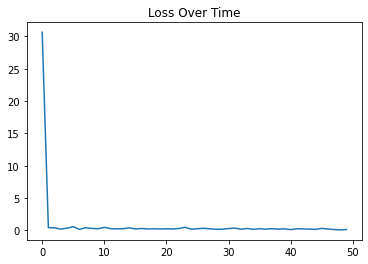

In [15]:
plt.plot(history.history["loss"][::10])
plt.title("Loss Over Time")
plt.show()